In [1]:
%matplotlib nbagg
from collections import deque
import gym
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf

C:\Users\daniel\Anaconda5.0.1-Python3.6\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## CartPole-v0

In [2]:
env = gym.make("CartPole-v0")

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [3]:
obs = env.reset()
obs

array([0.00185899, 0.04968145, 0.01059236, 0.03643618])

In [4]:
# plt.imshow(env.render(mode='rgb_array'))

In [5]:
def plot_enviroment(env, figsize=(5,4)):
    plt.close()  # or else nbagg sometimes plots in the previous cell
    plt.figure(figsize=figsize)
    img = env.render(mode='rgb_array')
    plt.imshow(img)
    plt.axis('off')
    plt.show()    

In [2]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    plt.close()  # or else nbagg sometimes plots in the pervious cell
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    return animation.FuncAnimation(fig, update_scene, fargs=(frames, patch), 
                                   frames=len(frames), repeat=repeat, interval=interval)

In [7]:
env.action_space

Discrete(2)

In [8]:
action = 0  # accelerate left

In [9]:
obs, reward, done, info = env.step(action)
obs

array([ 0.00285261, -0.14559078,  0.01132109,  0.33244219])

In [10]:
reward

1.0

In [11]:
done

False

In [12]:
info

{}

In [13]:
def basic_policy(obs):
    angle = obs[2]
    return 0 if angle < 0 else 1

In [14]:
totals = []
for episode in range(500):
    episode_rewards = 0
    obs = env.reset()
    for step in range(200):  # 200 steps max, we don't want to run forever
        action = basic_policy(obs)
        obs, reward, done, info = env.step(action)
        episode_rewards += reward
        if done:
            break
    totals.append(episode_rewards)

In [15]:
np.mean(totals), np.std(totals), np.min(totals), np.max(totals)

(42.078, 8.604877454095439, 24.0, 71.0)

In [ ]:
frames = []

obs = env.reset()
for step in range(200):
    img = env.render(mode='rgb_array')
    frames.append(img)
    action = basic_policy(obs)
    obs, reward, done, info = env.step(action)
    if done:
        break
#video = plot_animation(frames)
#plt.show()

In [16]:
tf.reset_default_graph()

learning_rate = 0.01

# 1. Specify the neural network architecture
n_inputs = 4  # == env.observation_space.shape[0]
n_hidden = 4  # it's a simple task, we don't need more hidden neurons
n_outputs = 1  # only outputs the probability of accelerating left
initializer = tf.keras.initializers.he_normal()

# 2. Build the neural network
X = tf.placeholder(tf.float32, shape=[None, n_inputs])
hidden = tf.layers.dense(X, n_hidden, activation=tf.nn.elu, kernel_initializer=initializer)
logits = tf.layers.dense(hidden, n_outputs, kernel_initializer=initializer)
outputs = tf.nn.sigmoid(logits)

# 3. Select a random action based on the estimated probabilities
p_left_and_right = tf.concat(axis=1, values=[outputs, 1 - outputs])
action = tf.multinomial(tf.log(p_left_and_right), num_samples=1)

y = 1. - tf.to_float(action)  # Assume the chosen action is the best possible action

cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)
optimizer = tf.train.AdamOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(cross_entropy)

gradients = [grad for grad, variable in grads_and_vars]

gradient_placeholders = []
grads_and_vars_feed = []
for grad, variable in grads_and_vars:
    gradient_placeholder = tf.placeholder(tf.float32, shape=grad.get_shape())
    gradient_placeholders.append(gradient_placeholder)
    grads_and_vars_feed.append((gradient_placeholder, variable))
    
training_op = optimizer.apply_gradients(grads_and_vars_feed)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [17]:
def discount_rewards(rewards, discount_rate):
    discounted_rewards = np.empty(len(rewards))
    cumulative_rewards = 0
    for step in reversed(range(len(rewards))):
        cumulative_rewards = rewards[step] + cumulative_rewards * discount_rate
        discounted_rewards[step] = cumulative_rewards
    return discounted_rewards

In [18]:
def discount_and_normalize_rewards(all_rewards, discount_rate):
    all_discounted_rewards = [discount_rewards(rewards, discount_rate) for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean) / reward_std for discounted_rewards in all_discounted_rewards]

In [19]:
discount_rewards([10, 0, -50], discount_rate=0.8)

array([-22., -40., -50.])

In [20]:
discount_and_normalize_rewards([[10, 0, -50], [10, 20]], discount_rate=0.8)

[array([-0.28435071, -0.86597718, -1.18910299]),
 array([1.26665318, 1.0727777 ])]

In [21]:
n_iterations = 250  # number of training iterations
n_max_steps = 200  # max steps per episode
n_games_per_update = 10  # train the policy every 10 episodes
save_iterations = 10  # save the model every 10 training iterations
discount_rate = 0.95

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        all_rewards = []  # all sequences of raw rewards for each episode
        all_gradients = []  # gradients saved at each step of each episode
        for game in range(n_games_per_update):
            current_rewards = []  # all raw rewards from the current episode
            current_gradients = []  # all gradients from the current episode
            obs = env.reset()
            for step in range(n_max_steps):
                action_val, gradients_val = sess.run([action, gradients], feed_dict={X: obs.reshape(1, n_inputs)})  # one obs
                obs, reward, done, info = env.step(action_val[0][0])
                current_rewards.append(reward)
                current_gradients.append(gradients_val)
                if done:
                    break
            all_rewards.append(current_rewards)
            all_gradients.append(current_gradients)
            
        # At this point we have run the policy for 10 episodes, and we are 
        # ready for a policy update using the algorithm described earlier.
        all_rewards = discount_and_normalize_rewards(all_rewards, discount_rate)
        feed_dict = {}
        for var_index, grad_placeholder in enumerate(gradient_placeholders):
            # multiply the gradients by the action scores, and compute the mean
            mean_gradients = np.mean(
                [
                    reward * all_gradients[game_index][step][var_index] 
                    for game_index, rewards in enumerate(all_rewards)
                    for step, reward in enumerate(rewards)
                ],
                axis=0
            )
            feed_dict[grad_placeholder] = mean_gradients
            
        sess.run(training_op, feed_dict=feed_dict)
        if iteration % save_iterations == 0:
            saver.save(sess, "./cartpole_checkpoint.ckpt")

In [27]:
def render_policy_net(model_path, action, X, n_max_steps=200):
    frames = []
    env = gym.make("CartPole-v0")
    obs = env.reset()
    with tf.Session() as sess:
        saver.restore(sess, model_path)
        for step in range(n_max_steps):
            img = env.render(mode="rgb_array")
            frames.append(img)
            action_val = action.eval(feed_dict={X: obs.reshape(1, n_inputs)})
            obs, reward, done, info = env.step(action_val[0][0])
            if done:
                break
        env.close()
        return frames

In [ ]:
frames = render_policy_net("./cartpole_checkpoint.ckpt", action, X)
video = plot_animation(frames)
plt.show()

In [35]:
def evaluate_policy_net(model_path, action, X):
    env = gym.make("CartPole-v0")
    totals = []
    with tf.Session() as sess:
        saver.restore(sess, model_path)
        for episode in range(100):
            episode_rewards = 0
            obs = env.reset()
            for step in range(200):  # 200 steps is the maximum for the enviroment
                action_val = action.eval(feed_dict={X: obs.reshape(1, n_inputs)})
                obs, reward, done, info = env.step(action_val[0][0])
                episode_rewards += reward
                if done:
                    break
            totals.append(episode_rewards)
    env.close()
    print(np.mean(totals), np.std(totals), np.min(totals), np.max(totals))

In [36]:
evaluate_policy_net("./cartpole_checkpoint.ckpt", action, X)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from ./cartpole_checkpoint.ckpt
192.6 17.513994404475525 118.0 200.0


## Markov Chains

In [28]:
transition_probs = [
    [0.7, 0.2, 0.0, 0.1],
    [0.0, 0.0, 0.9, 0.1],
    [0.0, 1.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 1.0],
]

n_max_steps = 50

def print_sequence(start_state=0):
    current_state = start_state
    print("States:", end=" ")
    for step in range(n_max_steps):
        print(current_state, end=" ")
        if current_state == 3:
            break
        current_state = np.random.choice(range(4), p=transition_probs[current_state])
    else:
        print("...", end="")
    print()
    
for _ in range(10):
    print_sequence()

States: 0 0 0 3 
States: 0 0 0 0 0 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 
States: 0 0 0 0 0 0 0 1 2 1 2 1 2 1 2 1 2 1 2 1 3 
States: 0 0 1 2 1 2 1 2 1 2 1 3 
States: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 1 2 1 2 1 2 1 2 1 3 
States: 0 0 0 0 0 3 
States: 0 0 0 0 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 
States: 0 0 0 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 
States: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 
States: 0 0 0 1 2 1 2 1 2 1 3 


## Markov Decision Process

In [37]:
nan = np.nan
transition_probs = np.array([  # shape=[s, a, s']
    [[0.7, 0.3, 0.0], [1.0, 0.0, 0.0], [0.8, 0.2, 0.0]],
    [[0.0, 1.0, 0.0], [nan, nan, nan], [0.0, 0.0, 1.0]],
    [[nan, nan, nan], [0.8, 0.1, 0.1], [nan, nan, nan]],
])

rewards = np.array([  # shape=[s, a, s']
    [[10.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0]],
    [[0.0, 0.0, 0.0], [nan, nan, nan], [0.0, 0.0, -50.0]],
    [[nan, nan, nan], [40.0, 0.0, 0.0], [nan, nan, nan]],
])

possible_actions = [[0, 1, 2], [0, 2], [1]]

In [ ]:
# Q-Value Iteration method

Q = np.full((3, 3), -np.inf)  # -inf for impossible actions
for state, actions, in enumerate(possible_actions):
    Q[state, actions] = 0.0  # 0.0 for possible actions
    
discount_rate = 0.95
n_iterations = 100

for iteration in range(n_iterations):
    Q_prev = Q.copy()
    for s in range(3):
        for a in possible_actions[s]:
            Q[s, a] = np.sum([
                transition_probs[s, a, sp] * (rewards[s, a, sp] + discount_rate * np.max(Q_prev[sp]))
                for sp in range(3)
            ])

In [38]:
Q

array([[21.88646117, 20.79149867, 16.854807  ],
       [ 1.10804034,        -inf,  1.16703135],
       [       -inf, 53.8607061 ,        -inf]])

In [39]:
np.argmax(Q, axis=1)  # optimal action for each state

array([0, 2, 1], dtype=int64)

In [45]:
def policy_learned(state):
    return [0, 2, 1][state]

def policy_random(state):
    return np.random.choice(possible_actions[state])

def policy_safe(state):
    return [0, 0, 1][state]

In [51]:
n_episodes = 1000
n_iterations = 100
state = 0  # start in state 0

for policy in [policy_learned, policy_random, policy_safe]:
    run_rewards = []
    for episode in range(n_episodes):
        total_reward = 0
        for iteration in range(n_iterations):
            action = policy(state)
            new_state = np.random.choice(range(3), p=transition_probs[state, action])
            total_reward += rewards[state, action, new_state]
            state = new_state
        run_rewards.append(total_reward)
    run_rewards = np.array(run_rewards)

    print("Policy:", policy.__name__,
          "Average reward:", np.mean(run_rewards), 
          "Std. reward:", np.std(run_rewards), 
          "Min reward:", np.min(run_rewards), 
          "Max reward:", np.max(run_rewards))

Policy: policy_learned Average reward: 127.03 Std. reward: 134.85725453233874 Min reward: -370.0 Max reward: 590.0
Policy: policy_random Average reward: -24.91 Std. reward: 87.13088947095628 Min reward: -310.0 Max reward: 330.0
Policy: policy_safe Average reward: 0.03 Std. reward: 0.9482088377567465 Min reward: 0.0 Max reward: 30.0


## Q-Learning

In [53]:
class MDPEnviroment:
    def __init__(self, start_state=0):
        self.start_state=start_state
        self.reset()
    
    def reset(self):
        self.state = self.start_state
        
    def step(self, action):
        next_state = np.random.choice(range(3), p=transition_probs[self.state][action])
        reward = rewards[self.state][action][next_state]
        self.state = next_state
        return self.state, reward

In [125]:
# Completely random

learning_rate = 0.01
discount_rate = 0.99
n_iterations = 40000

Q = np.full((3, 3), -np.inf)  # -inf for impossible actions
for state, actions in enumerate(possible_actions):
    Q[state, actions] = 0.0  # 0.0 for possible actions
    
optimal_actions = []
env = MDPEnviroment()
for iteration in range(n_iterations):
    s = env.state
    a = np.random.choice(possible_actions[s])  # choose an action (randomly)
    sp, reward = env.step(a)
    
    Q[s, a] = ((1 - learning_rate) * Q[s, a] + learning_rate * (reward + discount_rate * np.max(Q[sp])))
    optimal_actions.append(np.argmax(Q, axis=1))

In [126]:
Q

array([[65.47865905, 63.02731618, 59.80427678],
       [42.0322326 ,        -inf, 43.57300422],
       [       -inf, 94.61033883,        -inf]])

In [127]:
np.argmax(Q, axis=1)  # optimal action for each state

array([0, 2, 1], dtype=int64)

<IPython.core.display.Javascript object>


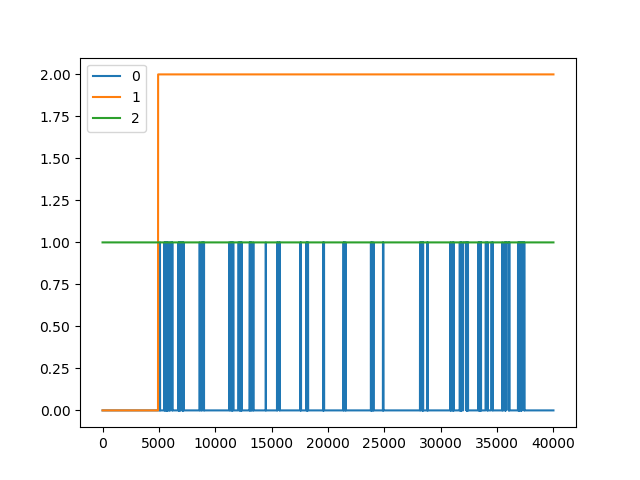

In [128]:
plt.close()
plt.plot(np.vstack(optimal_actions))
plt.legend(["0", "1", "2"])

In [129]:
# Greedy version

learning_rate = 0.01
discount_rate = 0.99
starting_greed = 1.0
ending_greed = 0.05
n_iterations = 40000
greed_values = np.linspace(starting_greed, ending_greed, n_iterations)

Q = np.full((3, 3), -np.inf)  # -inf for impossible actions
for state, actions in enumerate(possible_actions):
    Q[state, actions] = 0.0  # 0.0 for possible actions

optimal_actions = []
env = MDPEnviroment()
for iteration in range(n_iterations):
    s = env.state
    if random.random() < greed_values[iteration]:
        a = np.random.choice(possible_actions[s])  # act randomly
    else:
        a = np.argmax(Q, axis=1)[s]  # Use current q-values
    sp, reward = env.step(a)

    Q[s, a] = ((1 - learning_rate) * Q[s, a] + learning_rate * (reward + discount_rate * np.max(Q[sp])))
    optimal_actions.append(np.argmax(Q, axis=1))

In [130]:
Q

array([[ 89.08487449,  80.40387651,  77.8628781 ],
       [ 57.62394242,         -inf,  69.95547414],
       [        -inf, 122.00578363,         -inf]])

In [131]:
np.argmax(Q, axis=1)  # optimal action for each state

array([0, 2, 1], dtype=int64)

<IPython.core.display.Javascript object>


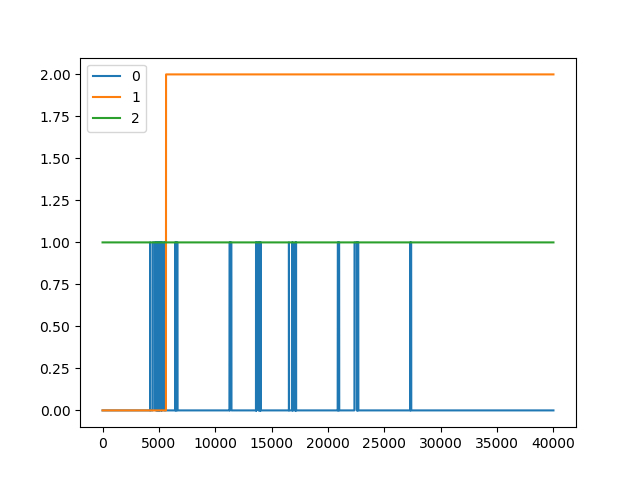

In [132]:
plt.close()
plt.plot(np.vstack(optimal_actions))
plt.legend(["0", "1", "2"])

In [133]:
# Exploration version

learning_rate = 0.01
discount_rate = 0.99
starting_greed = 1.0
ending_greed = 0.05
curiosity_value = 1.0
n_iterations = 40000
greed_values = np.linspace(starting_greed, ending_greed, n_iterations)

Q = np.full((3, 3), -np.inf)  # -inf for impossible actions
for state, actions in enumerate(possible_actions):
    Q[state, actions] = 0.0  # 0.0 for possible actions
    
N = np.full((3, 3), -np.inf)
for state, actions in enumerate(possible_actions):
    N[state, actions] = 0.0

optimal_actions = []
env = MDPEnviroment()
for iteration in range(n_iterations):
    s = env.state
    if random.random() < greed_values[iteration]:
        a = np.random.choice(possible_actions[s])  # act randomly
    else:
        a = np.argmax(Q, axis=1)[s]  # Use current q-values
    sp, reward = env.step(a)

    exploratory_value = Q[sp] + curiosity_value / (1 + N[sp])
    Q[s, a] = ((1 - learning_rate) * Q[s, a] + learning_rate * (reward + discount_rate * np.max(exploratory_value)))
    N[sp, a] += 1.0
    optimal_actions.append(np.argmax(Q, axis=1))

In [134]:
Q

array([[ 68.97744524,  64.31760675,  60.23872626],
       [ 42.29665063,         -inf,  47.94922905],
       [        -inf, 100.43706652,         -inf]])

In [135]:
np.argmax(Q, axis=1)

array([0, 2, 1], dtype=int64)

<IPython.core.display.Javascript object>


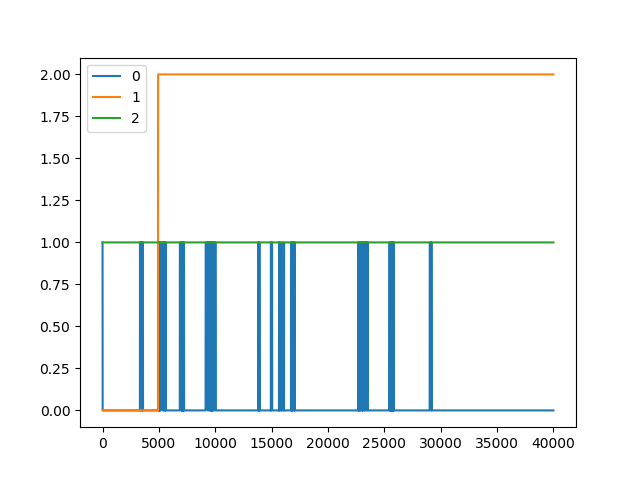

In [136]:
plt.close()
plt.plot(np.vstack(optimal_actions))
plt.legend(["0", "1", "2"])

## Deep Q-Network (DQN)

In [3]:
env = gym.make("MsPacman-v0")

In [4]:
obs = env.reset()
obs.shape

(210, 160, 3)

In [5]:
env.action_space

Discrete(9)

In [6]:
mspacman_color = np.array([210, 164, 74]).mean()

def preprocess_observation(obs):
    img = obs[1:176:2, ::2]  # crop and downsize
    img = img.mean(axis=2)  # to grayscale
    img[img==mspacman_color] = 0  # improve contrast
    img = (img - 128) / 128 - 1  # normalize from -1 to 1
    return img.reshape(88, 80, 1)

<IPython.core.display.Javascript object>


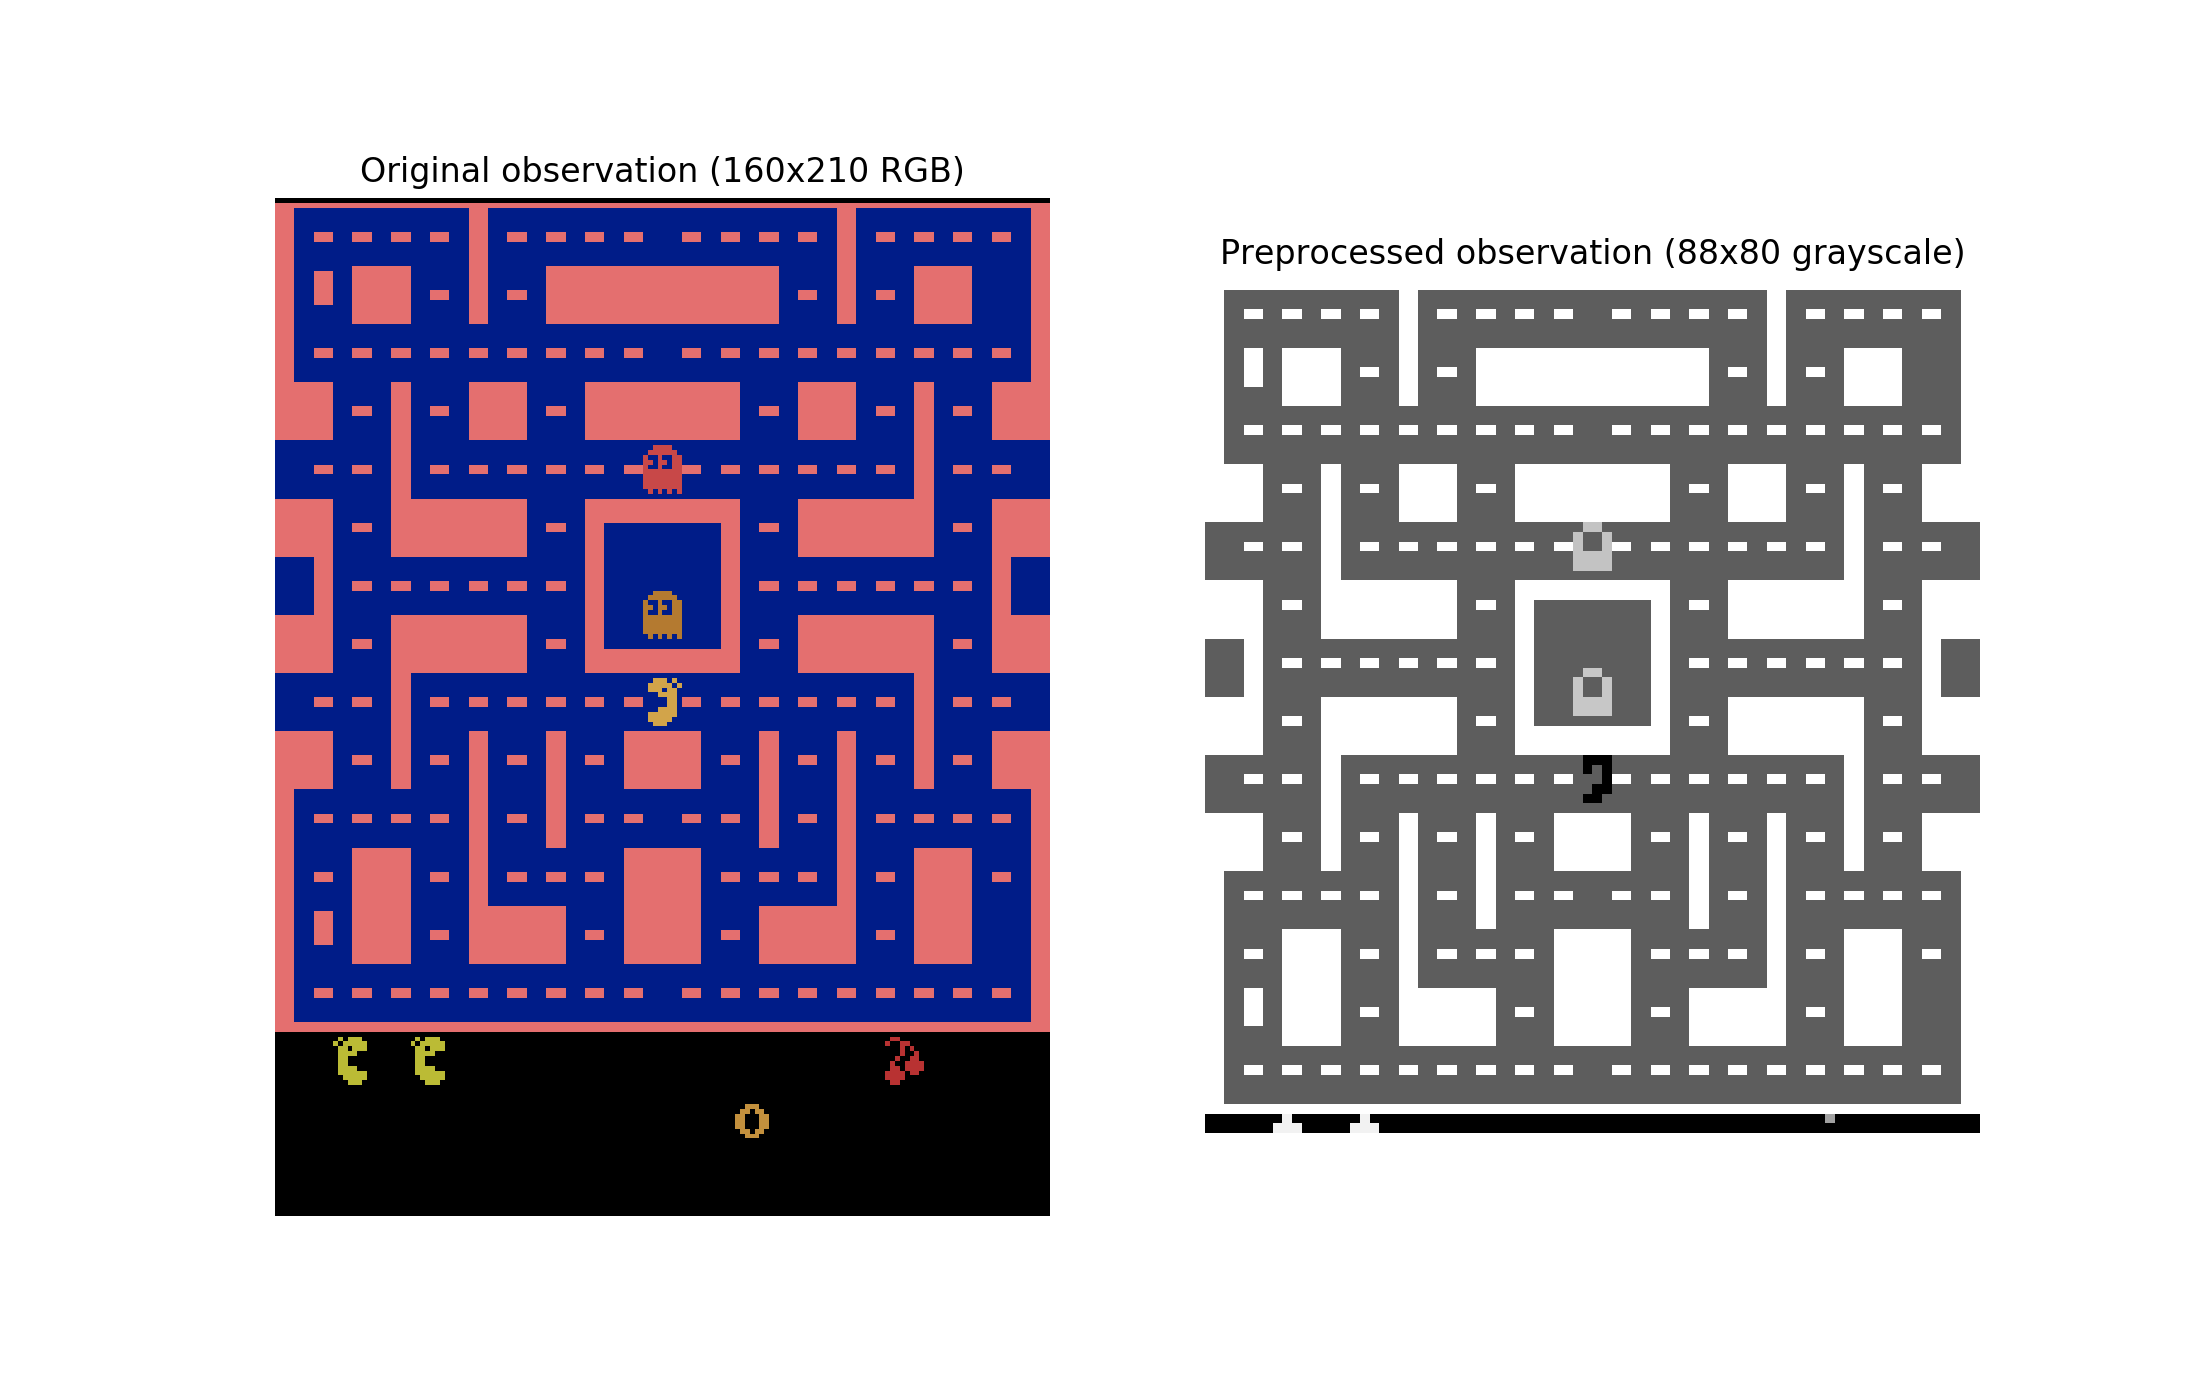

In [7]:
plt.figure(figsize=(11, 7))
plt.subplot(121)
plt.title("Original observation (160x210 RGB)")
plt.imshow(obs)
plt.axis("off")
plt.subplot(122)
plt.title("Preprocessed observation (88x80 grayscale)")
plt.imshow(preprocess_observation(obs).reshape(88, 80), interpolation="nearest", cmap="gray")
plt.axis("off")
plt.show()

In [10]:
input_height = 88
input_width = 80
input_channels = 1
conv_n_maps = [32, 64, 64]
conv_kernel_sizes = [(8, 8), (4, 4), (3, 3)]
conv_strides = [4, 2, 1]
conv_paddings = ["SAME"] * 3
conv_activation = [tf.nn.relu] * 3
n_hidden_in = 64 * 11 * 10  # conv3 has 64 maps of 11x10 each
n_hidden = 512
hidden_activation = tf.nn.relu
n_outputs = env.action_space.n  # 9 discrete actions are available
initializer = tf.keras.initializers.he_normal()

def q_network(X_state, name):
    prev_layer = X_state
    with tf.variable_scope(name) as scope:
        conv_iter = zip(conv_n_maps, conv_kernel_sizes, conv_strides, conv_paddings, conv_activation)
        for n_maps, kernel_size, strides, padding, activation in conv_iter:
            prev_layer = tf.layers.conv2d(
                prev_layer,
                filters=n_maps,
                kernel_size=kernel_size,
                strides=strides,
                padding=padding,
                activation=activation,
                kernel_initializer=initializer,
            )
        last_conv_layer_flat = tf.reshape(prev_layer, shape=[-1, n_hidden_in])
        hidden = tf.layers.dense(last_conv_layer_flat, n_hidden, activation=hidden_activation, kernel_initializer=initializer)
        outputs = tf.layers.dense(hidden, n_outputs, kernel_initializer=initializer)
    trainable_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=scope.name)
    trainable_vars_by_name = {var.name[len(scope.name):]: var for var in trainable_vars}
    return outputs, trainable_vars_by_name

In [11]:
tf.reset_default_graph()

X_state = tf.placeholder(tf.float32, shape=[None, input_height, input_width, input_channels])
online_q_values, online_vars = q_network(X_state, name="q_networks/online")
target_q_values, target_vars = q_network(X_state, name="q_networks/target")

copy_ops = [target_var.assign(online_vars[var_name]) for var_name, target_var in target_vars.items()]
copy_online_to_target = tf.group(*copy_ops)

In [12]:
online_vars

{'/conv2d/bias:0': <tf.Variable 'q_networks/online/conv2d/bias:0' shape=(32,) dtype=float32_ref>,
 '/conv2d/kernel:0': <tf.Variable 'q_networks/online/conv2d/kernel:0' shape=(8, 8, 1, 32) dtype=float32_ref>,
 '/conv2d_1/bias:0': <tf.Variable 'q_networks/online/conv2d_1/bias:0' shape=(64,) dtype=float32_ref>,
 '/conv2d_1/kernel:0': <tf.Variable 'q_networks/online/conv2d_1/kernel:0' shape=(4, 4, 32, 64) dtype=float32_ref>,
 '/conv2d_2/bias:0': <tf.Variable 'q_networks/online/conv2d_2/bias:0' shape=(64,) dtype=float32_ref>,
 '/conv2d_2/kernel:0': <tf.Variable 'q_networks/online/conv2d_2/kernel:0' shape=(3, 3, 64, 64) dtype=float32_ref>,
 '/dense/bias:0': <tf.Variable 'q_networks/online/dense/bias:0' shape=(512,) dtype=float32_ref>,
 '/dense/kernel:0': <tf.Variable 'q_networks/online/dense/kernel:0' shape=(7040, 512) dtype=float32_ref>,
 '/dense_1/bias:0': <tf.Variable 'q_networks/online/dense_1/bias:0' shape=(9,) dtype=float32_ref>,
 '/dense_1/kernel:0': <tf.Variable 'q_networks/online/de

In [13]:
X_action = tf.placeholder(tf.int32, shape=[None])
q_value = tf.reduce_sum(online_q_values * tf.one_hot(X_action, n_outputs), axis=1, keepdims=True)

In [14]:
y = tf.placeholder(tf.float32, shape=[None, 1])
error = tf.abs(y - q_value)
clipped_error = tf.clip_by_value(error, 0.0, 1.0)
linear_error = 2 * (error - clipped_error)
loss = tf.reduce_mean(tf.square(clipped_error) + linear_error)

In [15]:
learning_rate = 0.001
momentum = 0.95

global_step = tf.Variable(0, trainable=False, name="global_step")
optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
training_op = optimizer.minimize(loss, global_step=global_step)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [16]:
replay_memory_size = 500000
replay_memory = deque([], maxlen=replay_memory_size)

def sample_memories(batch_size):
    indices = np.random.permutation(len(replay_memory))[:batch_size]
    cols = [[], [], [], [], []]  # state, action, reward, next_state, continue
    for idx in indices:
        memory = replay_memory[idx]
        for col, value in zip(cols, memory):
            col.append(value)
    cols = [np.array(col) for col in cols]
    return (cols[0], cols[1], cols[2].reshape(-1, 1), cols[3], cols[4].reshape(-1, 1))

In [17]:
greed_min = 0.1
greed_max = 1.0
greed_decay_steps = 2000000

def greedy(q_values, step):
    greed = max(greed_min, greed_max - (greed_max - greed_min) * step / greed_decay_steps)
    if np.random.rand() < greed:
        return np.random.randint(n_outputs)  # random_action
    else:
        return np.argmax(q_values)  # "optimal" action

In [18]:
n_steps = 4000000  # total number of training steps
training_start = 10000  # start training after 10,000 game iterations
training_interval = 4  # run a training step every 4 game iterations
save_steps = 1000  # save the model every 1,000 training steps
copy_steps = 10000  # copy online DQN to target DQN every 10,000 training steps
discount_rate = 0.99
skip_start = 90  # Skip the start of every game (it's just waiting time)
batch_size = 50
iteration = 0  # game iterations
checkpoint_path = "./mspacman.ckpt"
done = True  # env needs to be reset

In [17]:
loss_val = np.infty
game_length = 0
total_max_q = 0
mean_max_q = 0.0

In [25]:
env = gym.make("MsPacman-v0")

with tf.Session() as sess:
    if os.path.isfile(checkpoint_path + ".index"):
        saver.restore(sess, checkpoint_path)
    else:
        init.run()
        copy_online_to_target.run()
    while True:
        step = global_step.eval()
        if step >= n_steps:
            break
        iteration += 1
        print("\rIteration {}\tTraining step {}/{} ({:.1f})%\tLoss {:5f}\tMean Max-Q {:5f}   "
              .format(iteration, step, n_steps, step * 100 / n_steps, loss_val, mean_max_q),
              end="")
        if done:  # game over, start again
            obs = env.reset()
            for skip in range(skip_start):  # skip the start of the game
                obs, reward, done, info = env.step(0)
            state = preprocess_observation(obs)
            
        # Online DQN evaluates what to do
        q_values = online_q_values.eval(feed_dict={X_state: [state]})
        action = greedy(q_values, step)
        
        # Online DQN plays
        obs, reward, done, info = env.step(action)
        next_state = preprocess_observation(obs)
        
        # Let's memorize what happened
        replay_memory.append((state, action, reward, next_state, 1.0 - done))
        state = next_state
        
        # Compute statistics for tracking progress
        total_max_q += q_values.max()
        game_length += 1
        if done:
            mean_max_q = total_max_q / game_length
            total_max_q = 0.0
            game_length = 0
            
        if iteration < training_start or iteration % training_interval != 0:
            continue  # only train after warmup period and at regular intervals
            
        # Sample memories and use the target DQN to produce the target Q-values
        X_state_val, X_action_val, rewards, X_next_state_val, continues = (sample_memories(batch_size))
        next_q_values = target_q_values.eval(feed_dict={X_state: X_next_state_val})
        max_next_q_values = np.max(next_q_values, axis=1, keepdims=True)
        y_val = rewards + continues * discount_rate * max_next_q_values
        
        # Train the online DQN
        _, loss_val = sess.run([training_op, loss], feed_dict={X_state: X_state_val, X_action: X_action_val, y: y_val})
        
        # Regularly copy the online DQN to the target DQN
        if step % copy_steps == 0:
            copy_online_to_target.run()
            
        # And save regularly
        if step % save_steps == 0:
            saver.save(sess, checkpoint_path)

INFO:tensorflow:Restoring parameters from ./mspacman.ckpt
Iteration 360791	Training step 87680/4000000 (2.2)%	Loss 1.143022	Mean Max-Q 1.456373    

KeyboardInterrupt: 

In [26]:
frames = []
n_max_steps = 10000

with tf.Session() as sess:
    saver.restore(sess, checkpoint_path)
    
    env = gym.make("MsPacman-v0")
    env.reset()
    for step in range(n_max_steps):
        state = preprocess_observation(obs)
        
        # Online DQN evaluates what to do
        q_values = online_q_values.eval(feed_dict={X_state: [state]})
        action = np.argmax(q_values)
        
        # Online DQN plays
        obs, reward, done, info = env.step(action)
        
        img = env.render(mode="rgb_array")
        frames.append(img)
        
        if done:
            break
        
    env.close()

INFO:tensorflow:Restoring parameters from ./mspacman.ckpt


KeyboardInterrupt: 

In [ ]:
video = plot_animation(frames)
plt.show()